#Классификация кожных заболеваний

Научная группа AI Research при медицинском университете получила датасет с фотографиями кожных поражений, причём с размеченными заболеваниями.
Основной целью исследования является разработка модели для классификации.

##Загрузка нужных библиотек и написание собственных функций

In [1]:
pip install torchvision

In [2]:
import os
import subprocess
import glob
from pathlib import Path
from datasets import load_dataset
import zipfile
import PIL.Image as Image
from IPython.display import display
import torch
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

In [3]:
#функция для изучения данных на аномальные значения и попуски
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def anomaly(data):
  #сли передан Series, преобразуем его в DataFrame
  if isinstance(data, pd.Series):
    data = data.to_frame()
  #выводим размер датасета
  print(f'Размер файла:{data.shape}')
  print('-'*100)
  #для вывода всех столбцов создаем цикл
  #выделяем в отдельную переменную названия столбцов
  column_data= data.columns
  #циклом перебираем все значения и выводим данные
  for c in column_data:
    #выводим все уникальные значения
    print(f'Уникальные значения показателя: {c}')
    print(data[c].unique())
    #считаем количество уникальных значений
    print(f'Количество уникальных значений: {data[c].nunique()}')
    #считаем количество всех значений
    print(f'Количество всех значений: {data[c].count()}')
    print('-'*100)

In [4]:
#функция для оценки пропусков в данных
#функция принимает на вход DataFrame, выводит текстовые сообщения на консоль
def nan_counts(df):
  #считаем количество пропусков в строке
  nan_counts = df.isna().sum(axis=1)
  #проверяем, какие строки имеют более половины NaN
  half_nan_rows = nan_counts > len(df.columns) / 2
  #количество строк с более чем половиной NaN
  num_half_nan_rows = half_nan_rows.sum()
  #вывод результатов
  print(f"\nОбщее количество строк с более чем половиной NaN: {num_half_nan_rows}")

In [5]:
#функция для исследовательского анализа качественных данных с использованием круговой диаграммы
#функция принимает данные и считает их количество внутри каждого уникального значения,
#после выводит круговой график
#функция принимает на вход DataFrame, выводит графики на консоль
def analisys_cat_pie(data, labels=None):
    if labels is not None:
      data = data.map(labels)

    data.value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(5, 5))
    plt.title('Круговая диаграмма показателя', size=10)
    plt.show()

In [6]:
#функция отображает изображения из DataFrame с соответствующими классами.
def show_images(df):
    for index, row in df.iterrows():
        img_path = row['path']
        class_label = row['class_label']
        display(Image(filename=img_path))
        print(f"Класс: {class_label}")
        print("-" * 50)

In [7]:
#функция для отображения изображений по индексу в DataFrame
def view_images(df, indices):
    #если передан единственный индекс, делаем его списковым
    if isinstance(indices, int):
        indices = [indices]

    #проходим по указанным индексам и отображаем изображения
    for idx in indices:
        #берём путь к изображению
        img_path = df.at[idx, 'path']

        #открываем изображение с помощью PIL
        img = Image.open(img_path)

        #выводим изображение
        display(img)
        print(f"Изображение для строки {idx}:\n")

##Загрузка и первичная оценка данных

Т к предложенный на сайте-источнике данных метод скачивание данных не рабоатет из-за повреждения архива в источнике, напишем отдельную функцию и скачаем только обучающие данные (они не повреждены). Далее будем работать только с обучающей выборкой, то есть примем ее как изначальный датасет и в дальнешем будем делить на обучающую и тестовые.

In [8]:
# скачивание и распаковка датасета ISIC
def download_and_extract_isic(data_url: str, labels_url: str,
                              data_zip: str = 'ISIC-2017_Training_Data.zip',
                              labels_csv: str = 'ISIC-2017_Training_Part3_GroundTruth.csv',
                              extract_dir: str = 'ISIC2017_Training') -> None:

    # удаление старых файлов, если существуют
    for path in [data_zip, extract_dir, 'ISIC2017_Sample']:
        if os.path.exists(path):
            if os.path.isdir(path):
                subprocess.run(['rm', '-rf', path])
            else:
                os.remove(path)

    # скачиваем архив и файл с метками
    subprocess.run(['wget', '-O', data_zip, data_url], check=True)
    subprocess.run(['wget', '-O', labels_csv, labels_url], check=True)

    # распаковываем архив
    subprocess.run(['unzip', '-o', data_zip, '-d', extract_dir], check=True)

In [9]:
download_and_extract_isic(
    data_url = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip',
    labels_url= 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part3_GroundTruth.csv'
)

In [10]:
labels_df = pd.read_csv('ISIC-2017_Training_Part3_GroundTruth.csv')
print('Размерность таблицы с метками:', labels_df.shape)
labels_df.head(4)

Размерность таблицы с метками: (2000, 3)


,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0


In [11]:
ls -F ISIC2017_Training/

ISIC-2017_Training_Data/


In [12]:
# пути к изображениям
image_paths = glob.glob('ISIC2017_Training/ISIC-2017_Training_Data/*.jpg')
print(f"Количество найденных изображений: {len(image_paths)}")

Количество найденных изображений: 2000


In [13]:
# преобразуем в DataFrame
paths_df = pd.DataFrame({
    'image_id': [os.path.splitext(os.path.basename(p))[0] for p in image_paths],
    'path': image_paths
})

# объединяем по image_id
data_df = labels_df.merge(paths_df, on='image_id', how='inner')

print('Размер общего датасета:', data_df.shape)

Размер общего датасета: (2000, 4)


In [14]:
data_df.head(10)

,image_id,melanoma,seborrheic_keratosis,path
0,ISIC_0000000,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
1,ISIC_0000001,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
2,ISIC_0000002,1.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
3,ISIC_0000003,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
4,ISIC_0000004,1.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
5,ISIC_0000006,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
6,ISIC_0000007,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
7,ISIC_0000008,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
8,ISIC_0000009,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...
9,ISIC_0000010,0.0,0.0,ISIC2017_Training/ISIC-2017_Training_Data/ISIC...


##Предобработка данных

Задачи:

1. Изучить данные на предмет пропусков.

2. Изучить данные на предмет явных дубликатов.


Неявные дубликаты в данных изучить вручную сложно, т к это требует просмтра всех изображений. То есть с помощью простых функций это сделать нельзя. На данный момент из-за специфики загрузки метода, вместо изображений отображаются ссылки на места их хранения. В связи с этим, вся преобработка изображений будет проведена в разделе подготовки данных. Для удобства проведения исследовательского анализа фотографии будут находится в "оригинальном" отображении.

In [15]:
print('Общий размер датасета до предобработки данных:', data_df.shape)

Общий размер датасета до предобработки данных: (2000, 4)


In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image_id              2000 non-null   object 
 1   melanoma              2000 non-null   float64
 2   seborrheic_keratosis  2000 non-null   float64
 3   path                  2000 non-null   object 
dtypes: float64(2), object(2)
memory usage: 62.6+ KB


In [17]:
data_df.columns

Index(['image_id', 'melanoma', 'seborrheic_keratosis', 'path'], dtype='object')

Как видно, датасет состоит из 4 колонок.

- image_id: это id изображения, т к не несет важной информации для модеди, при подготовке данных к обучению будет удален;

- melanoma: наличие или отсутвие меланомы (0 - нет, 1 - да);

- seborrheic_keratosis: наличие или отсутсвие себорейного кератоза (0 - нет, 1 - да).

Датасет не содержит изображения с отдельной меткой норма. При исследовательском анализе необходимо будет изучить, есть ли изображения с отсутствием меланомы и кератоза одновременно.

In [18]:
chec = ['melanoma', 'seborrheic_keratosis']

for c in chec:
  print(f'Анализ столбца {c}')
  anomaly(data_df[c])
  print('-'*100)

Анализ столбца melanoma
Размер файла:(2000, 1)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: melanoma
[0. 1.]
Количество уникальных значений: 2
Количество всех значений: 2000
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Анализ столбца seborrheic_keratosis
Размер файла:(2000, 1)
----------------------------------------------------------------------------------------------------
Уникальные значения показателя: seborrheic_keratosis
[0. 1.]
Количество уникальных значений: 2
Количество всех значений: 2000
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


In [19]:
col = data_df.columns

for c in col:
  print(f'Количество пропусков в столбце {c}: {data_df[c].isna().sum()} или {data_df[c].isna().sum()/len(data_df[c])*100} %')
  print('-'*100)

Количество пропусков в столбце image_id: 0 или 0.0 %
----------------------------------------------------------------------------------------------------
Количество пропусков в столбце melanoma: 0 или 0.0 %
----------------------------------------------------------------------------------------------------
Количество пропусков в столбце seborrheic_keratosis: 0 или 0.0 %
----------------------------------------------------------------------------------------------------
Количество пропусков в столбце path: 0 или 0.0 %
----------------------------------------------------------------------------------------------------


In [20]:
data_df.duplicated().sum()

np.int64(0)

**Вывод:** данные не имеют пропусков и явных дубликатов.

##Исcледовательский анализ данных

Задачи:

1. Изучить распространенность заболеваний в датасете

2. Изучить, есть ли представители в датасете, у который не поставлены данные диагнозы. Если такие есть, изучить фотографии.

Исследовательский анализ столбца melanoma


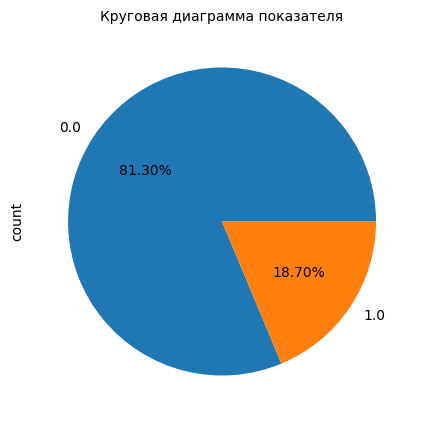

----------------------------------------------------------------------------------------------------
Исследовательский анализ столбца seborrheic_keratosis


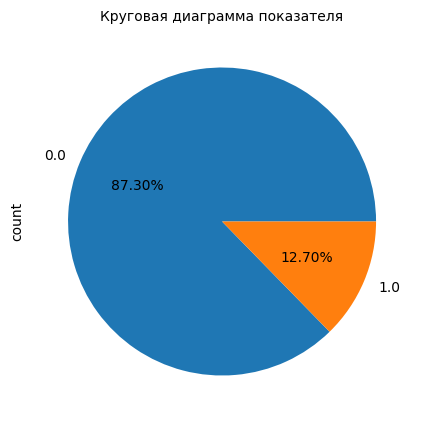

----------------------------------------------------------------------------------------------------


In [21]:
for c in chec:
  print(f'Исследовательский анализ столбца {c}')
  analisys_cat_pie(data_df[c])
  print('-'*100)

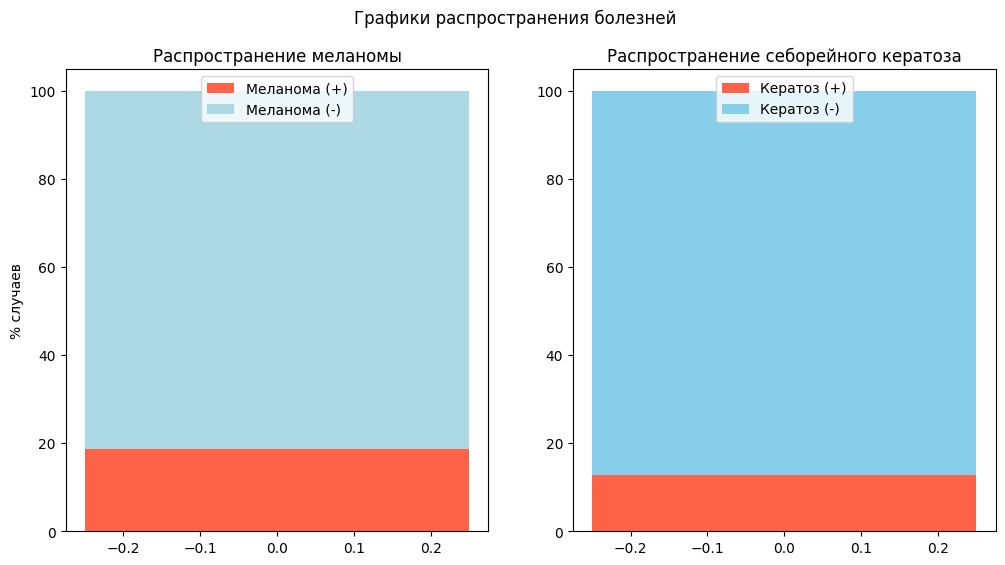

In [22]:
df = data_df[['melanoma', 'seborrheic_keratosis']]


fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# меланома
m_counts = df['melanoma'].value_counts(normalize=True)*100
axes[0].bar([0], m_counts.loc[1], color='#FF6347', label='Меланома (+)', width=0.5)
axes[0].bar([0], m_counts.loc[0], bottom=m_counts.loc[1], color='#ADD8E6', label='Меланома (-)', width=0.5)
axes[0].set_ylabel('% случаев')
axes[0].legend(loc='upper center')
axes[0].set_title('Распространение меланомы')

# себорейный кератоз
k_counts = df['seborrheic_keratosis'].value_counts(normalize=True)*100
axes[1].bar([0], k_counts.loc[1], color='#FF6347', label='Кератоз (+)', width=0.5)
axes[1].bar([0], k_counts.loc[0], bottom=k_counts.loc[1], color='#87CEEB', label='Кератоз (-)', width=0.5)
axes[1].legend(loc='upper center')
axes[1].set_title('Распространение себорейного кератоза')

# настройка общей подписи
plt.suptitle('Графики распространения болезней')
plt.show()


In [23]:
#изучим процент пациентов, у которых нет диагнозов
norma = data_df.query('melanoma == 0 and seborrheic_keratosis == 0')
print(f'Процент пациентов без установленного диагноза: {round(len(norma)/len(data_df)*100,2)} %')

Процент пациентов без установленного диагноза: 68.6 %


То есть в датасете 68 % пациентов, у которых не стоит данных диагноз. Изучим фотографии, т к в описании к датасету есть комментарий, что при разметке диагнозов была поставлена задача "заболивание или невус". То есть ожидаемо на изображениях кожи пациентов без диагнозов дб образования, которые при разметке получили класс "невус".

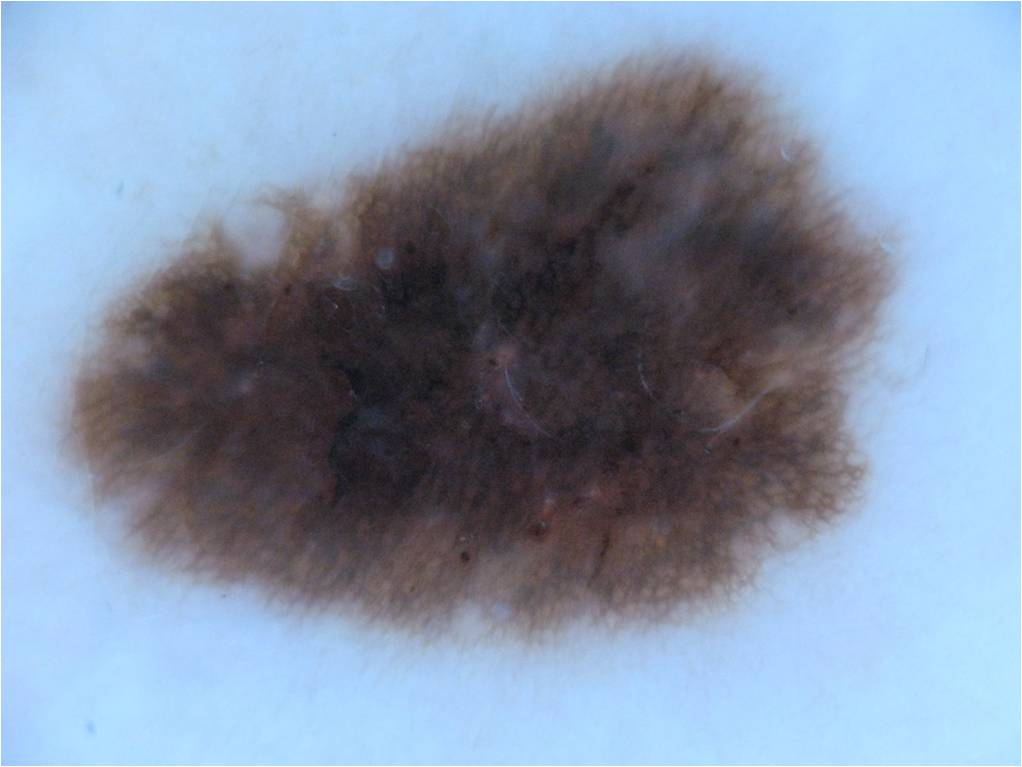

Изображение для строки 0:



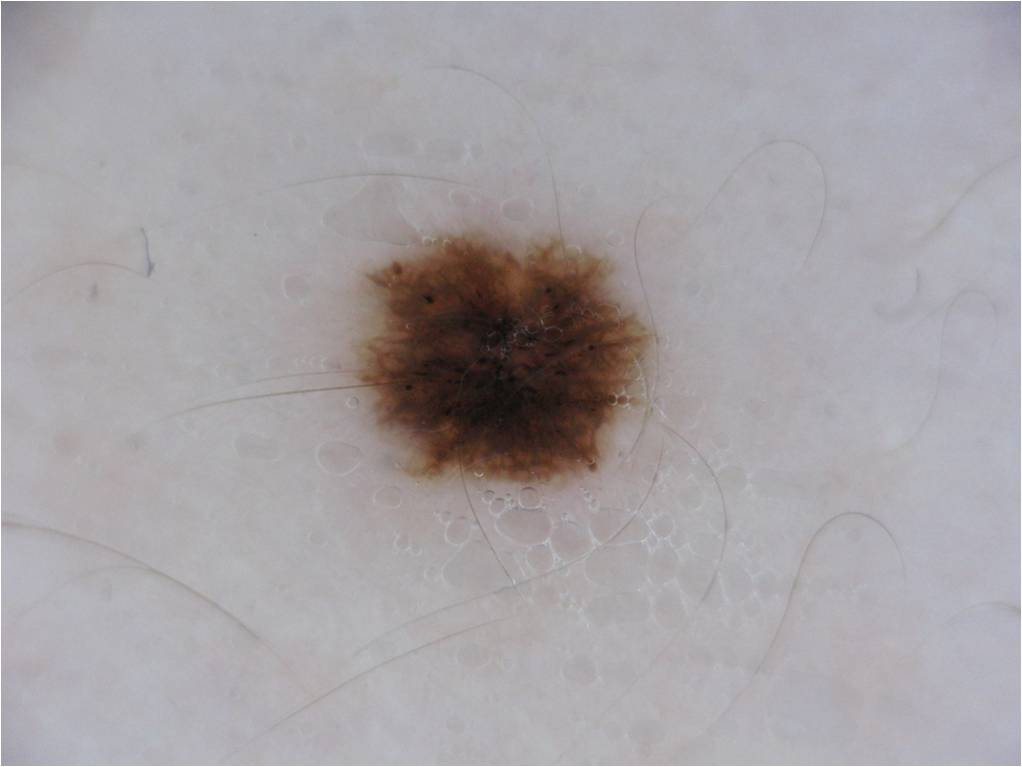

Изображение для строки 1:



In [24]:
view_images(norma, [0,1])

На изображениях есть на коже образование, то есть отсутсвие диагнозов не предполагает "чистую кожу", а наличие невуса, как и было описано в преамбуле к датасету.

Так же изучим, есть ли данные с "двойным" диагнозом

In [25]:
bad = data_df.query('melanoma == 1 and seborrheic_keratosis == 1')
print(f'Процент пациентов c установленным "двойным" диагнозом: {round(len(bad)/len(data_df)*100,2)} %')

Процент пациентов c установленным "двойным" диагнозом: 0.0 %


Перейдем к изучению статистики изображений.

In [26]:
#пустой список для статистики
stats = []

for index, row in data_df.iterrows():
    img_path = row['path']

    #открываем изображение с помощью PIL
    img = Image.open(img_path)

    #рассчитываем среднюю яркость (усредняем интенсивность пикселей)
    brightness = np.mean(np.asarray(img.convert('L')))

    #получаем размеры изображения
    width, height = img.size

    stats.append({
        'image_id': row['image_id'],
        'brightness': brightness,
        'width': width,
        'height': height
    })

#переводим полученный список в датасет
stats_df = pd.DataFrame(stats)

In [27]:
#рассчитываем общую статистику и выведем значения
mean_brightness = stats_df['brightness'].mean()
mean_width = stats_df['width'].mean()
mean_height = stats_df['height'].mean()
std_width = stats_df['width'].std()
std_height = stats_df['height'].std()

# Выводим рассчитанные показатели
print(f"Средняя яркость изображений: {mean_brightness:.2f}")
print(f"Средняя ширина изображений: {mean_width:.2f}")
print(f"Средняя высота изображений: {mean_height:.2f}")
print(f"Стандартное отклонение ширины: {std_width:.2f}")
print(f"Стандартное отклонение высоты: {std_height:.2f}")

Средняя яркость изображений: 158.43
Средняя ширина изображений: 2734.29
Средняя высота изображений: 1877.67
Стандартное отклонение ширины: 1682.31
Стандартное отклонение высоты: 1081.42


**Общие выводы:**

1. В данных около 81 % пациентов без меланомы, около 87 % пациентов без себорейного кератоза. Из всех выборки пациентов 68 % - это пациенты с невусом.

2. По средней статистике изображений можно сделать вывод, что изображения без засветов, но по стандартным отклонениям ширины и высоты видно, что фотографии загружены разного размера.

##Предподготовка данных

Т к данные представлены только изображениями и столбцами с бинарными признаками. Для подготовки данных для обучения нужно провести следующие процедуры:

1. Удалить столбец с id, который не несет информацию нужную для обучения.

2. Создадим столбец с таргетным признаком. Создадим столбец с классом и присвоим класс в зависимости от комбинации меток.

3. Провести нормализацию изображений и подготовить их для обучения модели.

4. Разделить данные на обучающую и тестовую выборки.

In [28]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image_id              2000 non-null   object 
 1   melanoma              2000 non-null   float64
 2   seborrheic_keratosis  2000 non-null   float64
 3   path                  2000 non-null   object 
dtypes: float64(2), object(2)
memory usage: 62.6+ KB


In [29]:
data_df = data_df.drop('image_id', axis = 1)

In [30]:
#заявим константы
TARGET_SIZE = (224, 224)
TEST_SIZE = 0.15
RANDOM_STATE = 42

In [31]:
for index, row in data_df.iterrows():
    #если оба столбца содержат 0, то присвоим класс 0 (невус)
    if row['melanoma'] == 0 and row['seborrheic_keratosis'] == 0:
        data_df.at[index, 'class'] = 0
    #если стоит диагноз меланома - 1
    elif row['melanoma'] == 1:
        data_df.at[index, 'class'] = 1
    #если стоит диагноз кератоз - 2
    elif row['seborrheic_keratosis'] == 1:
        data_df.at[index, 'class'] = 2

In [32]:
#применение аугментации
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # меняем размер изображения
    transforms.RandomHorizontalFlip(p=0.5),  # горизонтальное переворачивание
    transforms.RandomRotation(30),           # случайный поворот
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # цветовые искажения
    transforms.ToTensor(),                   # преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # нормализация
])



In [33]:
X = []
y = []

for path, label in zip(data_df['path'], data_df['class']):
    # загружаем изображение
    img = Image.open(path).convert('RGB')

    # применяем преобразования
    transformed_image = transform(img)

    # добавляем преобразованный тензор и метку
    X.append(transformed_image)
    y.append(label)

# преобразуем список тензоров в единый тензор
X = torch.stack(X)
y = torch.tensor(y)

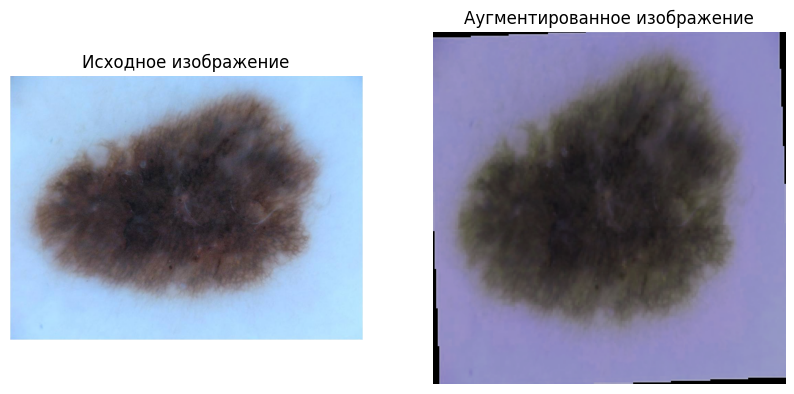

In [34]:
# восстанавливаем изображение из нормализованной формы
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    return tensor.mul(std[:, None, None]).add(mean[:, None, None])

# первая пара: путь к исходному изображению и соответствующее аугментированное изображение
first_original_path = data_df['path'].values[0]
# первое аугментированное изображение
first_transformed_image = X[0]


original_image = Image.open(first_original_path).convert('RGB')

# восстанавливаем нормальное представление аугментированного изображения
denorm_transform = denormalize(first_transformed_image)
denorm_np = denorm_transform.permute(1, 2, 0).clamp_(0, 1).numpy()  # Clamp ограничивает значения в диапазоне [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# оригинал
axes[0].imshow(np.asarray(original_image))
axes[0].set_title("Исходное изображение")
axes[0].axis('off')

# аугментированная версия
axes[1].imshow(denorm_np)
axes[1].set_title("Аугментированное изображение")
axes[1].axis('off')

plt.show()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

**Выводы:**

1. Для обучения модели столбцы с диагнозами были переработаны в общий столбец class. Каждой строке был присвоен класс исходя из комбинации диагнозов: 0 - невус, 1 - меланома, 2 - себорейный кератоз.

2. При предподготовке были проведены нормализаци всех изображений и аугментация обучающего датасета.

3. Датасет был разделен на обучающую и тестовую выборки.

##Обучение моделей

Обучим две модели TensorFlow и ResNet.

In [36]:
#заявим количество классов
num_classes = 3
input_shape = (224, 224, 3)

#во избежание нестабильности модели и однозначного разделения на классы
#переведем зачения классов в one-hot представление
y_train_encoded = to_categorical(y_train, num_classes=num_classes)

In [37]:
#меняем расположение столбцов в соответсвии с требованиями моделия
X_train_ = X_train.permute(0, 2, 3, 1)
X_test_ = X_test.permute(0, 2, 3, 1)

In [38]:
model = Sequential([
    # Первый свёрточный слой
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  # Первый пулинг

    # Второй свёрточный слой
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),  # Второй пулинг

    # Третий свёрточный слой (убираем третий пулинг)
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),

    # Полносвязные слои
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [39]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
epochs = 10
batch_size = 32

In [41]:
print("Размер X_train:", np.array(X_train_).shape)
print("Размер y_train_encoded:", y_train_encoded.shape)

Размер X_train: (1700, 224, 224, 3)
Размер y_train_encoded: (1700, 3)


In [42]:
history = model.fit(X_train_, y_train_encoded,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5895 - loss: 8.1608
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6743 - loss: 0.8828
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6870 - loss: 0.8438
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6749 - loss: 0.8457
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6750 - loss: 0.8522
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6605 - loss: 0.8553
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6905 - loss: 0.8105
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6695 - loss: 0.8040
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6960 - loss: 0.7180
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7010 - loss: 0.6910


In [43]:
_, accuracy = model.evaluate(X_train_, y_train_encoded)
print(f'Правильность на тренировочных данных: {accuracy}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7581 - loss: 0.5829
Правильность на тренировочных данных: 0.7370588183403015


In [44]:
pred = model.predict(X_test_)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step


In [45]:
#преобразуем вероятности в метки
predicted_labels = pred.argmax(axis=-1)

In [46]:
accuracy_tf = accuracy_score(y_test, predicted_labels)
print(f"Accuracy на тестовых данных: {accuracy_tf}")

Accuracy на тестовых данных: 0.7066666666666667


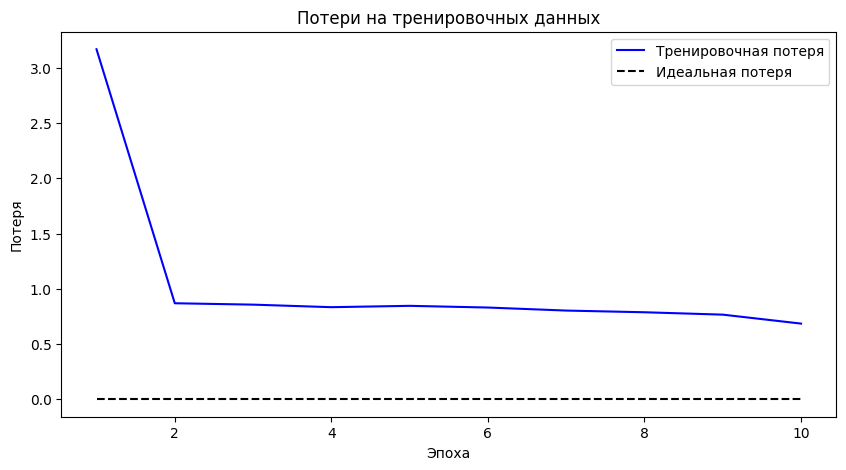

In [47]:
train_loss = history.history['loss']

# Эры обучения
epochs = range(1, len(train_loss) + 1)

# Идеальная линия стремления к нулю
ideal_line = [0]*len(train_loss)

# Визуализация функции потерь
plt.figure(figsize=(10, 5))

# Потеря на тренировочных данных
plt.plot(epochs, train_loss, 'b', label='Тренировочная потеря')
plt.plot(epochs, ideal_line, '--k', label='Идеальная потеря')
plt.title('Потери на тренировочных данных')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.show()

In [48]:
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

In [49]:
# подключаем базовую модель ResNet без верхнего слоя
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# блокируем обучение весов базовой модели (freeze)
base_model.trainable = False

# получаем выходные данные последней доступной части модели
output_layer = base_model.output

# добавляем global average pooling
output_layer = GlobalAveragePooling2D()(output_layer)

# добавляем полносвязный слой для классификации
output_layer = Dense(num_classes, activation='softmax')(output_layer)

# создаем новую модель
model_resnet = Model(inputs=base_model.input, outputs=output_layer)

In [50]:
model_resnet.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [51]:
history_resnet = model_resnet.fit(X_train_,
                                  y_train_encoded,
                                  epochs=10,
                                  batch_size=batch_size,
                                  validation_split=0.2)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 417ms/step - accuracy: 0.6793 - loss: 0.9004 - val_accuracy: 0.6382 - val_loss: 0.8890
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.6690 - loss: 0.8434 - val_accuracy: 0.6441 - val_loss: 0.8829
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7095 - loss: 0.7619 - val_accuracy: 0.6441 - val_loss: 0.8763
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6924 - loss: 0.7740 - val_accuracy: 0.6471 - val_loss: 0.9050
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6893 - loss: 0.7918 - val_accuracy: 0.6412 - val_loss: 0.8608
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7073 - loss: 0.7509 - val_accuracy: 0.6382 - val_loss: 0.8491
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6938 - loss: 0.7651 - val_accuracy: 0.6294 - val_loss: 0.8492
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.6982 - loss: 0.7355 - val_accuracy: 0

In [52]:
_, accuracy = model_resnet.evaluate(X_train_, y_train_encoded)
print(f'Правильность на тренировочных данных: {accuracy}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.7068 - loss: 0.7181
Правильность на тренировочных данных: 0.6917647123336792


In [53]:
pred_resnet = model_resnet.predict(X_test_)
pred_resnet_labels = pred_resnet.argmax(axis=-1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 840ms/step


In [54]:
accuracy_resnet = accuracy_score(y_test, pred_resnet_labels)
print(f"Accuracy на тестовых данных: {accuracy_tf}")

Accuracy на тестовых данных: 0.7066666666666667


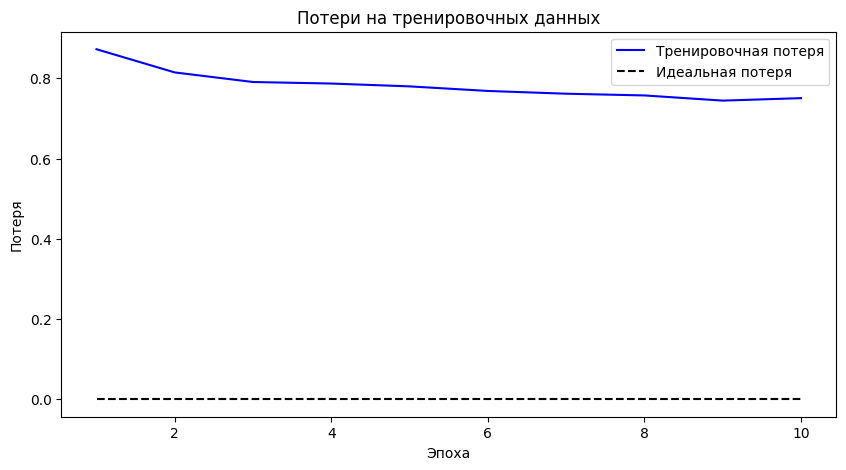

In [55]:
train_loss = history_resnet.history['loss']

# Эры обучения
epochs = range(1, len(train_loss) + 1)

# Идеальная линия стремления к нулю
ideal_line = [0]*len(train_loss)

# Визуализация функции потерь
plt.figure(figsize=(10, 5))

# Потеря на тренировочных данных
plt.plot(epochs, train_loss, 'b', label='Тренировочная потеря')
plt.plot(epochs, ideal_line, '--k', label='Идеальная потеря')
plt.title('Потери на тренировочных данных')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.show()

**Выводы:**

1. Обучили две модели TensorFlow и ResNet, данные предварительно прошли аугментацию.

2. Правильность получили для обеих моделей на обучающей выборке 0.74 для TensorFlow и 0.71 для ResNet, на тренировочных - 0.71 и 0.71 соотвественно.

3. На данный момент кандидатом для дальнейшей доработки является TensorFlow.

*Рекомендация для доработки:* подобрать гиперпараметры для модели. Т к изначально работа проводилась в среде Google Colab, к концу работы столкнулись с ограничениями Google, что замедлило работу и является сильным препятствием для доработки. В дальнейшем необходимо "пересесть" на локальную версию на ПК с вычислительными мощностями, которые позводяют работать с такими объемами данных.

In [56]:
print('Код не упал!')

Код не упал!
